In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
# def create_sequences(data, seq_length):
#     """
#     Creates sequences and their corresponding target sequences from the input data.

#     Args:
#         data (array-like): The input data.
#         seq_length (int): The length of each sequence.

#     Returns:
#         np.ndarray: Array of input sequences.
#         np.ndarray: Array of target sequences.
#     """
#     if len(data) < 2 * seq_length:
#         raise ValueError("Data length must be at least twice the sequence length.")

#     sequences = []
#     targets = []
    
#     for i in range(len(data) - 2 * seq_length + 1):
#         sequences.append(data[i:i+seq_length])               # Input sequence
#         targets.append(data[i+seq_length:i+2*seq_length])    # Target sequence of same length
    
#     return np.array(sequences), np.array(targets)


In [8]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 2  # Target is half the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [9]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.4):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 60)
val_seq1, val_labels1 = create_sequences(val_df1.values, 60)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)


In [10]:
train_seq_tensor1.shape

torch.Size([487, 60, 1])

In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 60)
val_seq2, val_labels2 = create_sequences(val_df2.values, 60)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)

In [12]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 60)
val_seq3, val_labels3 = create_sequences(val_df3.values, 60)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)

In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 60)
val_seq4, val_labels4 = create_sequences(val_df4.values, 60)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, :30, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 128
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [15]:
# Train model 1
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    # print(y_pred.shape)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.37034645676612854, Val Loss: 1.3884246349334717
Epoch 10, Train Loss: 0.36876633763313293, Val Loss: 1.4181244373321533
Epoch 20, Train Loss: 0.36842575669288635, Val Loss: 1.4365952014923096
Epoch 30, Train Loss: 0.36833035945892334, Val Loss: 1.4330723285675049
Epoch 40, Train Loss: 0.3681534230709076, Val Loss: 1.4201387166976929
Epoch 50, Train Loss: 0.3680115044116974, Val Loss: 1.4118211269378662
Epoch 60, Train Loss: 0.3678360879421234, Val Loss: 1.4086047410964966
Epoch 70, Train Loss: 0.36760735511779785, Val Loss: 1.405815839767456
Epoch 80, Train Loss: 0.3672455847263336, Val Loss: 1.4035030603408813
Epoch 90, Train Loss: 0.3665546476840973, Val Loss: 1.4041463136672974
Epoch 100, Train Loss: 0.36503785848617554, Val Loss: 1.406325101852417
Epoch 110, Train Loss: 0.3627687096595764, Val Loss: 1.4063080549240112
Epoch 120, Train Loss: 0.3586784303188324, Val Loss: 1.4679615497589111
Epoch 130, Train Loss: 0.3497144877910614, Val Loss: 1.5324839353561401

In [16]:
# Train model 2
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.44592711329460144, Val Loss: 1.429870843887329
Epoch 10, Train Loss: 0.44018101692199707, Val Loss: 1.4536986351013184
Epoch 20, Train Loss: 0.43441322445869446, Val Loss: 1.474014401435852
Epoch 30, Train Loss: 0.42681947350502014, Val Loss: 1.4867150783538818
Epoch 40, Train Loss: 0.41382744908332825, Val Loss: 1.4835991859436035
Epoch 50, Train Loss: 0.3881974518299103, Val Loss: 1.4404857158660889
Epoch 60, Train Loss: 0.3517519235610962, Val Loss: 1.2995880842208862
Epoch 70, Train Loss: 0.3118833303451538, Val Loss: 1.056662917137146
Epoch 80, Train Loss: 0.2680661082267761, Val Loss: 0.6765005588531494
Epoch 90, Train Loss: 0.2595403790473938, Val Loss: 0.43662795424461365
Epoch 100, Train Loss: 0.2528916001319885, Val Loss: 0.5160835981369019
Epoch 110, Train Loss: 0.2496788650751114, Val Loss: 0.5282772183418274
Epoch 120, Train Loss: 0.2458757758140564, Val Loss: 0.4988580048084259
Epoch 130, Train Loss: 0.24247315526008606, Val Loss: 0.5112085938453674

In [17]:
# Train model 3
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4484653174877167, Val Loss: 0.6417931914329529
Epoch 10, Train Loss: 0.4423771798610687, Val Loss: 0.6747503876686096
Epoch 20, Train Loss: 0.436470091342926, Val Loss: 0.7039876580238342
Epoch 30, Train Loss: 0.4288574457168579, Val Loss: 0.7284044623374939
Epoch 40, Train Loss: 0.4160713255405426, Val Loss: 0.744536280632019
Epoch 50, Train Loss: 0.3919007182121277, Val Loss: 0.7349897027015686
Epoch 60, Train Loss: 0.35759538412094116, Val Loss: 0.6294018030166626
Epoch 70, Train Loss: 0.3274436593055725, Val Loss: 0.3992534577846527
Epoch 80, Train Loss: 0.3203502297401428, Val Loss: 0.295244425535202
Epoch 90, Train Loss: 0.31113407015800476, Val Loss: 0.3980991542339325
Epoch 100, Train Loss: 0.30811503529548645, Val Loss: 0.42344337701797485
Epoch 110, Train Loss: 0.30575117468833923, Val Loss: 0.406015008687973
Epoch 120, Train Loss: 0.30352357029914856, Val Loss: 0.4158385694026947
Epoch 130, Train Loss: 0.3013732433319092, Val Loss: 0.40327581763267517


In [18]:
import copy
# Average the models
average_model = copy.deepcopy(model1)
models = [model1, model2, model3]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

In [19]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [29]:
test_seq4, test_labels4 = create_sequences(test_df.values, 60)
test_tensor_seq4 = torch.FloatTensor(test_seq4)
test_tensor_labels4 = torch.FloatTensor(test_labels4)

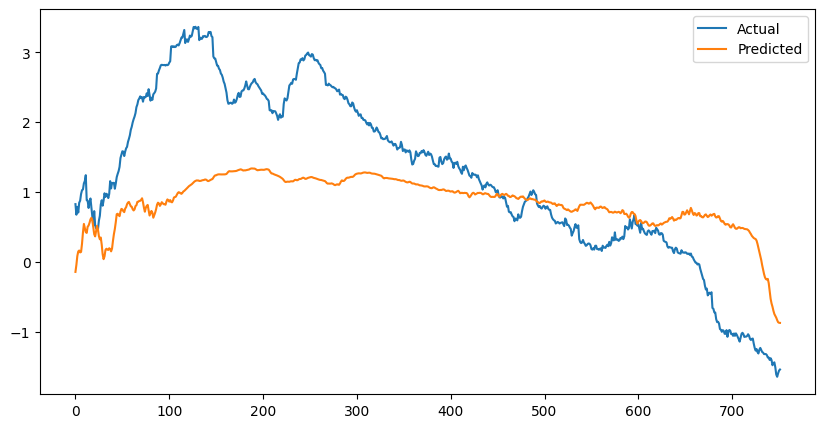

In [30]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 3,:].numpy(), label="Actual")
plt.plot(y_pred_test[:, 3, :].numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

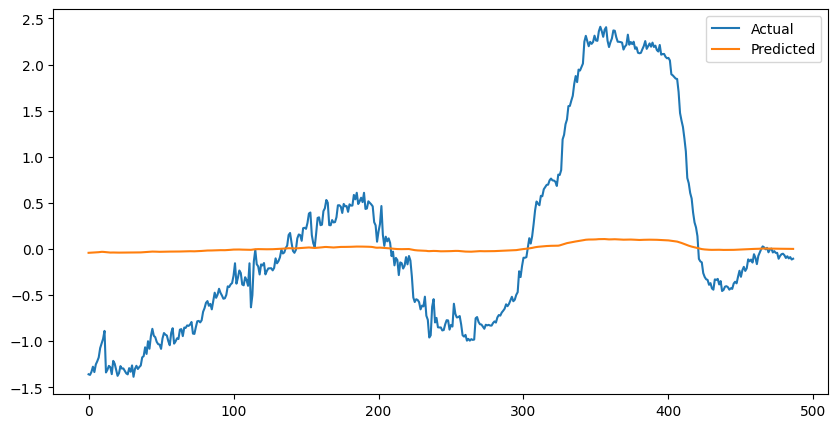

In [31]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(train_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_seq_tensor1[:, 3,:].numpy(), label="Actual")
plt.plot(y_pred_test[:, 5, :].numpy(), label="Predicted")
plt.legend()


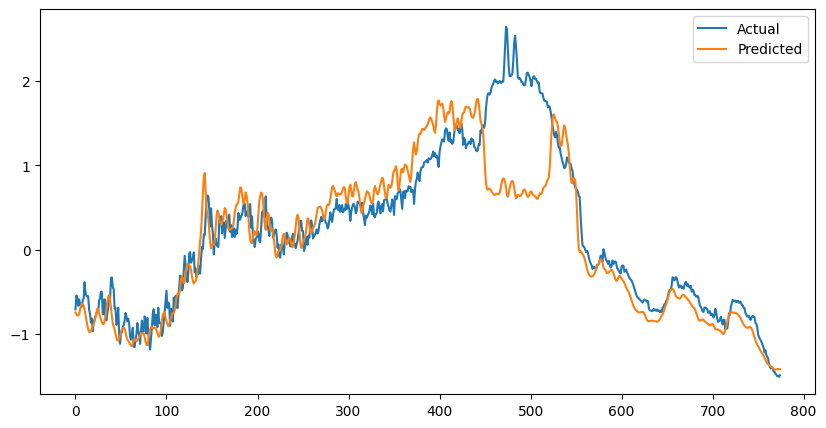

In [32]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(train_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_seq_tensor2[:, 0,:].numpy(), label="Actual")
plt.plot(y_pred_test[:, 5, :].numpy(), label="Predicted")
plt.legend()

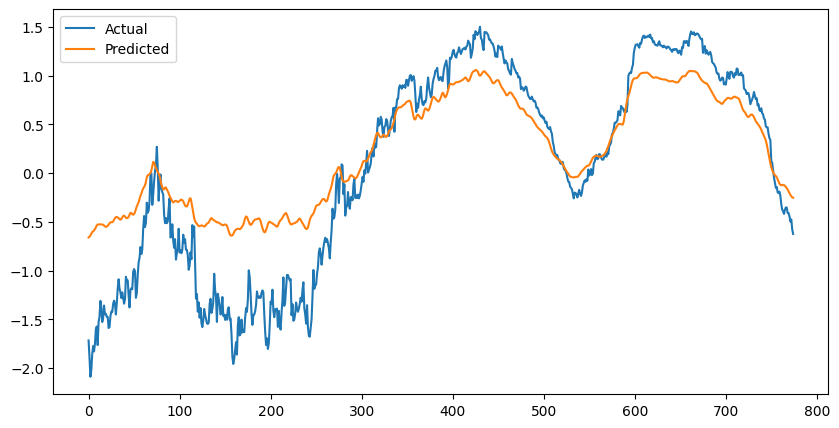

In [39]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(train_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_seq_tensor3[:, 0,:].numpy(), label="Actual")
plt.plot(y_pred_test[:, 5, :].numpy(), label="Predicted")
plt.legend()


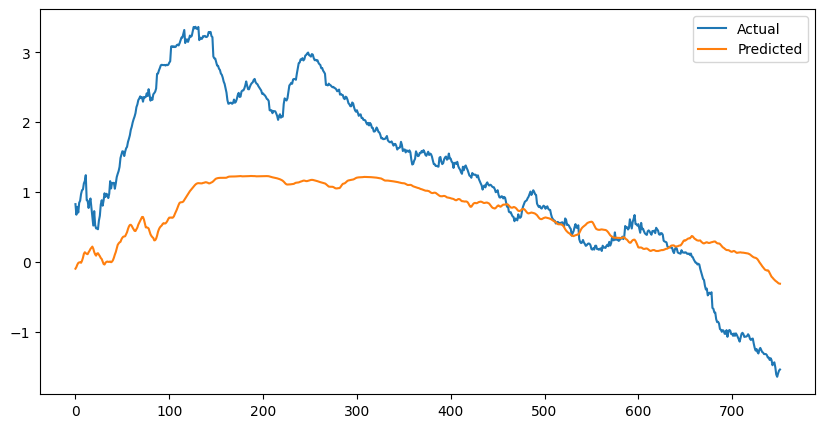

In [40]:
# model 2 and 3 only
import copy
# Average the models
average_model = copy.deepcopy(model3)
models = [model3, model2]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 3,:].numpy(), label="Actual")
plt.plot(y_pred_test[:, 3, :].numpy(), label="Predicted")
plt.legend()


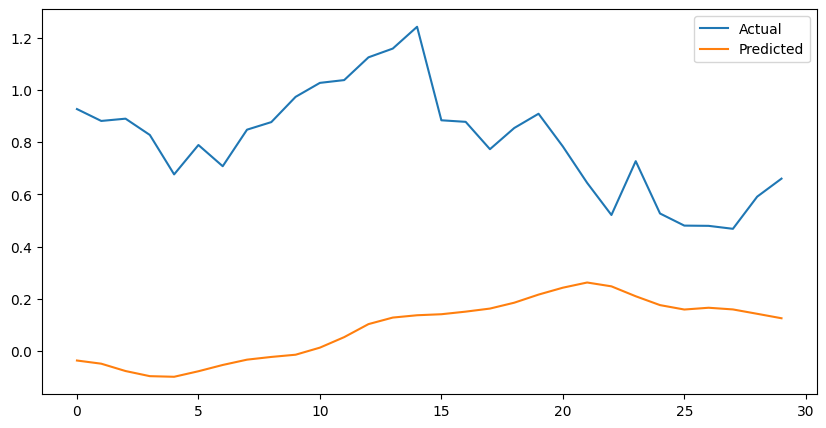

In [41]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[0, :,:].numpy(), label="Actual")
plt.plot(y_pred_test[0, :, :].numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [36]:
test_tensor_labels4.shape

torch.Size([752, 30, 1])